# Most Frequent Value procedures

Most Frequent Value (MFV) procedures and their theoretical background were developed by Ferenc Steiner and his research team almost 50 years ago. These procedures are applied to various problems in geostatistics. MFV methods have a clear advantage over statistics using Gaussian data distribution. To quote from the Introduction of the Basics of geostatistics [book](http://antikva.hu/geologia/a-geostatisztika-alapjai) of Ferenc Steiner (in Hungarian): "robust statistics is a theoretical framework for getting reliable and effective results while we are free from the (possibly catastrophic) bias of outliers." The first requirement, that is getting a reliable result even in case of significantly different data distributions is called **robustness** by Steiner. The second, that is to be free from the bias of outliers is called by him **resistance**.

Next we introduce the main idea of the MFV procedures and show its application through examples.

## Data, histograms and probability densities

Thickness data of brown coal deposit Borsod II. in the area Sajószentpéter-Múcsony are analyzed  in the textbook of Steiner (1990). Histogram of the data are shown in Fig. 1.2 from which the dataset ([deposit.dat](deposit.dat)) itself can be reconstructed.

Read these data and plot the histogram.

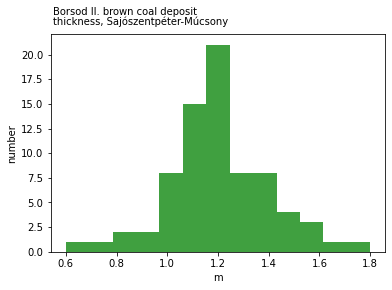

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Thickness data of brown coal deposit Borsod II. in the area Sajószentpéter-Múcsony
# Steiner F.: Basics of geostatistics, 1990, p.17.
# thickness of the deposit in m
dat = np.loadtxt('deposit.dat')

# plot histogram
n, bins, patches = plt.hist(dat, 13, density=False, facecolor='green', alpha=0.75)

plt.xlabel('m')
plt.ylabel('number')
plt.text(0.55,24, 'Borsod II. brown coal deposit')
plt.text(0.55,23, 'thickness, Sajószentpéter-Múcsony')
plt.show()

What distribution do these data follow? Although there are only 75 deposit thicknesses, and this is not quite enough to determine data distribution. let us try to fit a couple of known densities to the data.

We use the `scipy.stats` module and the function for [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) test in it.

IndentationError: unexpected indent (<ipython-input-5-17bd7d708126>, line 31)

It can be seen that data are best fitted with *not* a normal, but a Cauchy density. Is this exceptional? Let us see another dataset. Our dataset now consists of the residual Faye anomalies in the MGH-50 gravity network, which were reduced with the EGM2008 geopotential model to degree and order 2160. Let us try different densities.

cauchy          p: 0.04103362394533372      D: 0.15853756077008824
laplace         p: 0.027351019396592048     D: 0.16666666666666663
norm            p: 0.01850941954939358      D: 0.1741295092406836
uniform         p: 9.92194664537383e-05     D: 0.2533333333333333
-------------------------------------------------------------------
Best 4
-------------------------------------------------------------------
1    cauchy           	p:  0.04103362394533372 	D:  0.15853756077008824
2    laplace          	p:  0.027351019396592048 	D:  0.16666666666666663
3    norm             	p:  0.01850941954939358 	D:  0.1741295092406836
4    uniform          	p:  9.92194664537383e-05 	D:  0.2533333333333333


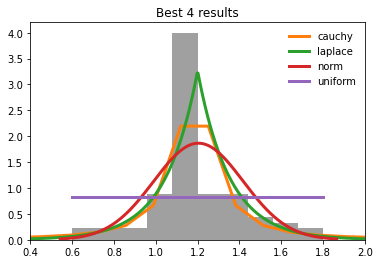

In [6]:
import scipy.stats
import math

cdfs = {
    "cauchy": {"p":[], "D": []},          #Cauchy
    "laplace": {"p":[], "D": []},         #Laplace
    "norm": {"p":[], "D": []},            #Normal (Gaussian)
    "uniform": {"p":[], "D": []}}         #Uniform

def check(data, fct, verbose=False):
    #fit data to all given distributions
    parameters = eval("scipy.stats."+fct+".fit(data)");
    #use Kolmogorov-Smirnov two-sided test
    D, p = scipy.stats.kstest(data, fct, args=parameters);

    if math.isnan(p): p=0
    if math.isnan(D): D=0

    if verbose:
        print(fct.ljust(16) + "p: " + str(p).ljust(25) + "D: " +str(D))

    return (fct, p, D)

def plot(fcts, data):
    import matplotlib.pyplot as plt
    import numpy as np

    # plot histogram of data
    plt.hist(data, density=True, bins=max(10, len(data)/10), facecolor='grey', alpha=0.75)

    # plot fitted densities
    for fct in fcts:
        params = eval("scipy.stats."+fct+".fit(data)")
        f = eval("scipy.stats."+fct+".freeze"+str(params))
        x = np.linspace(f.ppf(0.001), f.ppf(0.999), 500)
        plt.plot(x, f.pdf(x), lw=3, label=fct)
    plt.legend(loc='best', frameon=False)
    plt.title("Best "+str(len(fcts))+" results")
    plt.xlim([0.4,2.0])
    plt.show()

data = dat
results = [check(data, fct, True) for fct in cdfs.keys()]
for res in results:
    key, p, D = res
    cdfs[key]["p"].append(p)
    cdfs[key]["D"].append(D)

print( "-------------------------------------------------------------------" )
print( "Best %d" % (4, ) )
print( "-------------------------------------------------------------------" )
best = sorted(cdfs.items(), key=lambda elem : np.median(elem[1]["p"]), reverse=True)

for t in range(4):
    fct, values = best[t]
    print( str(t+1).ljust(4), fct.ljust(16),
            "\tp: ", np.median(values["p"]),
            "\tD: ", np.median(values["D"]),
            end="")
    if len(values["p"]) > 1:
        print("\tvar(p): ", scipy.var(values["p"]),
                "\tvar(D): ", scipy.var(values["D"]), end="")
    print()

plot([b[0] for b in best[:4]], data)


Now a Student PDF is the best fitting one. To quote Steiner (1990, p.145) "Newcomb ... stated at the end of the last century that it is very rare when our data follow a Gaussian density distribution (and we must add that Newcomb was also an astronomer, and astronomical measurements are famous for their accuracy). The authority of Gauss for many and for a long time lead to the general acceptance of Gaussian densities; if it was entirely different, e.g. the tails were much more heavy, the reliability of the measurements were questioned instead."

But do we really need to care about the fact that our data densities in practice are only exceptionally Gaussian (or normal)? The answer is: yes, and the reason of this is statistical **efficiency**.

## Statistical efficiency

In theory the definition of statistical efficiency of an estimate is:

*Statistical efficiency = 100 (information extracted / information contained) %*

We also need a practical definition of efficiency for numerical calculations. The following formula is suitable:

*e = 100 (minimal asymptotic variance / asymptotic variance) %*

The denominator must be evaluated for the particular statistical estimation. The numerator is the [Cramer-Rao bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound). If we evaluate this for the model family $f_a(x)$ or *supermodel* (which includes in the limit both Gaussian normal and Cauchy distributions)


$$f_a(x) = \frac{ \Gamma \left( \frac{a}{2} \right) }{\sqrt {\pi} \Gamma \left( \frac{a-1}{2} \right) } \frac{1}{(1+x^2)^{a/2}} $$

then we get the following very interesting figure (Steiner, 1997):
![](Steiner1.png)

It is clear that while the least squares estimate has 100% efficiency for a Gaussian density, for other densities with heavier tails its efficiency quickly deteriorates. And we must add that a 50% efficiency means we have wasted 50% of our data. In many cases this is unacceptable. But also it is seen that MFV estimates are robust, that is these are quite insensitive to data densities, evidenced by the high, over 90% efficiency.

[Idan and Speyer (2008)](http://folk.ntnu.no/skoge/prost/proceedings/cdc-2008/data/papers/1760.pdf) observed something similar in the context of scalar discrete linear systems entailing additive process and measurement noises: "the Cauchy receiver is robust in the entire class of *Sα-S* noises, while the Gaussian receiver degrades very quickly even if the Gaussian assumption is only slightly violated."

## Most Frequent Value

The main idea of the determination of the most frequent value (MFV) is to assign small or great weights ($\varphi$) to data that are far from or close to the place of the largest data density, the *weighted mean*

$$\frac{\sum_{i=1}^{n}\varphi_i x_i}{\sum_{i=1}^{n}\varphi_i}$$

provides a reliable, in most cases a much more reliable characteristic of the dataset in comparison with the arithmetic mean.

The implementation of the above main idea inevitably leads to an iterative algorithm since the "characteristic value" $M$ must be known beforehand to apply there maximal weights and correspondingly smaller weights the farther we are from this characteristic value.

Let us use the following simple and symmetrical weight function ($\epsilon$ is the width parameter of the weight function):

$$\varphi_i = \frac{\epsilon^2}{\epsilon^2+(x_i-M)^2}.$$

The following figure shows weight functions for various width parameters. ![](Steiner2.png)

Calculation of the **most frequent value** $M$ thus requires iteration for $M_n$ that satisfies the following equation:

$$M_n=\frac{\sum_{i=1}^{n}\frac{\epsilon^2}{\epsilon^2+(x_i-M_n)^2} x_i}{\sum_{i=1}^{n}\frac{\epsilon^2}{\epsilon^2+(x_i-M_n)^2}}.$$

Data farter from $M_n$ contribute less to $M_n$ due to the smaller weights, hence it is useful to consider the sum of weights in the denominator as an effective number of points [$n_{eff}(\epsilon)$]:

$$n_{eff}(\epsilon)=\sum_{i=1}^{n}\frac{\epsilon^2}{\epsilon^2+(x_i-M_n)^2}.$$

The maximization of the effective number of points is considered superior to the parallel minimization of $\epsilon$, and both of these goals are achieved for example with the maximization of the following expression:

$$\frac{n_{eff}^2(\epsilon)}{\epsilon}.$$

This is equivalent with the definition of the scale parameter $\epsilon$ that provides the extremum of

$$\sum_{i=1}^{n}\frac{\epsilon^{3/2}}{\epsilon^2+(x_i-M_n)^2} = \mathrm{maximum}.$$

The particular value of $\epsilon$ that provides the above extremum characterizes the tendency of cohesion of the majority of points in a sense that a large $\epsilon$ means small cohesion and vice versa. Hence it is advantageous to define cohesion like this:

$$ \kappa = \frac{1}{\epsilon}.$$

Therefore, $\epsilon$ could be called *reciprocal cohesion*, but for simplicity a better term would be **dihesion**.





Numerical values of $M_n$ and $\epsilon$ are obtained from two parallel iterations. It can be shown that $\epsilon$ can not be larger than $\sqrt{3}/2$ times the data range:

$$\epsilon \le \frac{\sqrt{3}}{2}[\mathrm{max}(x_i) - \mathrm{min}(x_i)].$$

We can pick sample mean or median as initial guess for $M_n$. Next we update $\epsilon$  using formula

$$\epsilon^2_{k+1}=\frac{3\sum_{i=1}^{n}\frac{(x_i-M_n)^2}{[\epsilon_k^2+(x_i-M_n)^2]^2}}{\sum_{i=1}^{n}\frac{1}{[\epsilon_k^2+(x_i-M_n)^2}]^2}.$$

Next update $M_n$ with this new $\epsilon$ using the formula already given, and continue updating $\epsilon$ and $M_n$ until convergence. Exprerience shows that 10-20 iterations provide values that are accurate enough.

The following Python function implements the above procedure:

In [7]:
def mfd(xk, k=1):
    # M,eps = mfd(xk) calculation of the most frequent value and dihesion
    # xk  : numpy data vector
    # k   : parameter of the generalized dihesion
    # M   : most frequent value
    # eps : dihesion

    # initial guess for dihesion
    e0 = np.sqrt(3.0)/2.0*(np.amax(xk)-np.amin(xk))
    # initial guess for the most frequent value: median
    M0 = np.median(xk)

    ej = e0
    Mj = M0
    while True:
        vk = xk - Mj
        se = 1.0/(ej**2+vk**2)
        num = vk*se
        den = se
        ej1 = np.sqrt(3.0*np.sum(num**2)/np.sum(den**2))
        se1 = 1.0/((k*ej1)**2+vk**2)
        Mj1 = np.sum(se1*xk)/np.sum(se1)
        if np.fabs(ej1-ej)/ej < 1e-6:
            if np.fabs(Mj1-Mj)/Mj < 1e-6:
                break
        ej = ej1
        Mj = Mj1
    return Mj1,ej1


Calculate characteristics of the deposit thickness dataset.

In [8]:
m,d = mfd(dat)
print ("")
print ("brown coal deposit thickness data")
print ("mean                : %.3f" % np.mean(dat))
print ("median              : %.3f" % np.median(dat))
print ("most frequent value : %.3f" % m)
print ("standard deviation  : %.3f" % np.std(dat))
print ("dihesion            : %.3f" % d)


brown coal deposit thickness data
mean                : 1.204
median              : 1.200
most frequent value : 1.185
standard deviation  : 0.214
dihesion            : 0.115


Median and most frequent value are *resistant*, i.e. insensitive to outliers. The same is true neither in case of the mean nor of standard deviation. Also, the Cauchy distribution has no standard deviation at all (it is infinitely large), but it has got a well-defined dihesion parameter, which is analogous to the standard deviation.

In [9]:
datk = np.append(dat,40.0)
m,d = mfd(datk)
print ("")
print ("brown coal deposit thickness data")
print ("mean                : %.3f" % np.mean(datk))
print ("median              : %.3f" % np.median(datk))
print ("most frequent value : %.3f" % m)
print ("standard deviation  : %.3f" % np.std(datk))
print ("dihesion            : %.3f" % d)


brown coal deposit thickness data
mean                : 1.714
median              : 1.200
most frequent value : 1.185
standard deviation  : 4.426
dihesion            : 0.115


## Generalized mosf frequent value

There is an useful generalization of the most frequent value:

$$M_{k;n}=\frac{\sum_{i=1}^{n}\frac{\epsilon^2}{(k\epsilon)^2+(x_i-M_{k;n})^2} x_i}{\sum_{i=1}^{n}\frac{\epsilon^2}{(k\epsilon)^2+(x_i-M_{k;n})^2}}.$$

In the previous figure the index of $M$ denoted this generalization.

## Maximum likelihood estimate for Cauchy density

Let us sample from a Cauchy density with location parameter $T$ and with unit width parameter:

$$ f_C(x,T)=\frac{1}{\pi} \frac{1}{1+(x-T)^2}.$$

What algorithm we must use for the maximum likelihood (ML) estimate of the location parameter $T$? The answer is provided by the maximum of the likelihood function:

$$ p(\vec{x},T) = \prod_{i=1}^n f_C(x_i,T)\cdot (\Delta x)^n = max.$$

or equivalently:

$$ \prod_{i=1}^n f_C(x_i,T)= max$$ or $$ \sum_{i=1}^n \ln f_C(x_i,T)= max.$$

For a Cauchy density (with omission of the factor $1/\pi$):

$$ \sum_{i=1}^n \ln  \frac{1}{1+(x-T)^2}= max$$

After differentiation

$$ \sum_{i=1}^n \frac{x_i-T}{1+(x-T)^2}= 0$$

If we "solve" this equation for $T$, we get an iteration formula:

$$ T = \frac{\sum_{i=1}^n \frac{x_i}{1+(x-T)^2}}{\sum_{i=1}^n \frac{1}{1+(x-T)^2}}.$$

If the width parameter of the density is $\epsilon$:

$$ T = \frac{\sum_{i=1}^n \frac{x_i}{\epsilon^2+(x-T)^2}}{\sum_{i=1}^n \frac{1}{\epsilon^2+(x-T)^2}} = M_n = \frac{\sum_{i=1}^n \frac{x_i}{\epsilon^2+(x-M_n)^2}}{\sum_{i=1}^n \frac{1}{\epsilon^2+(x-M_n)^2}}.$$

Now we recognize that ML estimation algorithm is identical with the algorithm of obtaining the _most frequent value_ for a Cauchy density. This conclusion holds true even for the more general supermodel $f_a(x)$.